# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Домашнее задание 11

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

<b><font color="blue">Легкая часть</font></b> (достаточно на "хор"):
* Задача 1 &mdash;  50 баллов

<b><font color="orange">Сложная часть</font></b> (необходимо на "отл"):
* Задача 2 &mdash;  40 баллов







-----

 Bot check

 HW_ID: phds_hw11
 Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

 Status: not final
 Перед отправкой в финальном решении удали "not" в строчке выше.
 Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
 Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


Импорты из sklearn:

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## Задача 1

In [156]:
def plot_results(y_to_train, y_to_test, y_forecast, title): 
    """
    Функция для визуализации временного ряда и предсказания.
    Параметры:
        - y_to_train: pd.Series размер T_train
            Временной ряд, на котором обучалась модель.
        - y_to_test: pd.Series размер T_test
            Временной ряд, который предсказывает модель.
        - y_forecast: array размер T_test
            Предсказания модели.
        - title: str
            Название графика
    """
    
    plt.figure(figsize=(15, 5))
    plt.title(title, fontsize=15) 
    plt.plot(y_to_train, label="train")
    plt.plot(y_to_test, label="test")
    plt.plot(y_to_test.index, y_forecast, label="prediction") 
    plt.legend()
    plt.show()

def calc_metrics(y_true, y_pred):
    """
    Функция для подсчета метрик качества прогноза
    Параметры:
        - y_true: np.array, pd.Series,  размер T_test
            Вектор истинных значений таргета
        - y_pred: np.array, pd.Series, размер T_test
            Векотр предсказанных знаяений таргета
    """

    print('MSE: ', mean_squared_error(y_true, y_pred))
    print('MAE: ', mean_absolute_error(y_true, y_pred))
    print('MAPE: ', mean_absolute_percentage_error(y_true, y_pred))


def create_date_features(date):
    """Создает фичи из даты"""
    
    row = {}
    row['dayofweek'] = date.dayofweek
    row['quarter'] = date.quarter
    row['month'] = date.month
    row['year'] = date.year
    row['dayofyear'] = date.dayofyear
    row['dayofmonth'] = date.day
    row['weekofyear'] = date.weekofyear
    return row


def create_only_date_train_features(y_series):
    """
        Создает обучающий датасет из признаков, полученных из дат для y_series
    """
    
    time_features = pd.DataFrame([create_date_features(date) for date in y_series.index])
    return time_features, y_series


def create_shifted_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1, mult = 24,
):
    """
    Создает обучающий датасет из признаков, полученных из дат и значений ряда ранее.
    При этом используются значения ряда со сдвигами на неделю и год назад.
    Параметры:
        - y_series: pd.Series, размер T
            временной ряд.
        - shifts: int
            дневной сдвиг (сколько дней учитываем).
        - week_seasonal_shifts: int
            недельный сдвиг (сколько недель учитываем).
        - year_seasonal_shifts: int
            годовой сдвиг (сколько лет учитываем).
    """
    
    curr_df, y = create_only_date_train_features(y_series)
    curr_df.index = y_series.index

    # применяем сдвиг по дням
    for shift in range(1, shifts + 1):
        curr_df[f'shift_{shift}'] = y_series.shift(mult * shift, axis=0)

    # применяем сдвиг по неделям
    for shift in range(1, week_seasonal_shifts + 1):
        curr_df[f'week_seasonal_shift_{shift}'] = y_series.shift(mult * 7*shift, axis=0)
    
    # применяем сдвиг по годам
    for shift in range(1, year_seasonal_shifts + 1):
        curr_df[f'year_seasonal_shift_{shift}'] = y_series.shift(365* mult * shift, axis=0)

    y = y_series
    
    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y

def row_features(
    date, y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1, mult = 24,
):
    
    curr_df = create_date_features(date)

    # применяем сдвиг по дням
    for shift in range(1, shifts + 1):
        curr_df[f'shift_{shift}'] = y_series[-mult * shift]

    # применяем сдвиг по неделям
    for shift in range(1, week_seasonal_shifts + 1):
        curr_df[f'week_seasonal_shift_{shift}'] = y_series[-mult * 7*shift]
    
    # применяем сдвиг по годам
    for shift in range(1, year_seasonal_shifts + 1):
        curr_df[f'year_seasonal_shift_{shift}'] = y_series[-365* mult * shift]

    return curr_df


def recursive_prediction(model, test_dates, y_to_train,features_creation_function=row_features):
    """
    Функция для рекурсивного предсказания для дат, указанных в test_dates.
    
    Параметры:
        - model
            Обученная МЛ-модель.
        - test_dates
            массив с датами, в которые надо сделать предсказания.
        - y_to_train
            Предыдущие значения
        - features_creation_function
            функция для создания тестовых признаков
    """

    predictions = []
    previous_y = y_to_train

    for date in test_dates:
        # получаем признаки для тестовых данных из тестовой даты и предыдущих значений
        features = features_creation_function(date,previous_y)
        # выоплняем предсказание моделью
        curr_prediction = model.predict(pd.DataFrame(features,index=[0])) 

        # добавляем текущее предсказание к предыдущем значениям в список previous_y
        previous_y.append(curr_prediction)

        # сохраняем текущее предсказание для вердикта на тесте в список predictions
        predictions.append(curr_prediction)
    
    return np.array(predictions)

#### **Профиль физика**

В этом задании мы будем работать с данными о загрязнении воздуха в Пекине, которые можно скачать [здесь](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data). В этой папке представлены несколько таблиц, данные в них сняты с различных станций. Для дальнейшей работы выберите любую таблицу.

 В данных представлены следующие колонки:

* `year, month, day, hour`  &mdash; год, месяц, день и час измерения

* `PM2.5` концентрация PM2.5 (ug/m^3). `PM2.5` &mdash; описывает мелкие вдыхаемые частицы, диаметр которых обычно составляет 2,5 микрометра и меньше.
* `PM10` концентрация PM10 (ug/m^3). `PM10` &mdash; любые твердые частицы в воздухе диаметром 10 микрометров или меньше, включая дым, пыль, сажу, соли, кислоты и металлы.
* `SO2`: концентрация SO2 (ug/m^3),
* `NO2`: концентрация NO2 (ug/m^3),
* `CO`: концентрация CO (ug/m^3),
* `O3`: концентрация O3 (ug/m^3),
* `TEMP`: температура (degree Celsius),
* `PRES`: давление (hPa=100Pa),
* `DEWP`: температура точки росы (degree Celsius),
* `RAIN`: атмосферные осадки (mm),
* `wd`: направление ветра,
* `WSPM`: скорость ветра (m/s),
* `station`: название станции.

Таргетом в этой задаче будет показатель загрязнения воздуха `PM10`.

In [124]:
data = pd.read_csv('PRSA_Data_Aotizhongxin_20130301-20170228.csv')

Колонка с исходными датами здесь отсутствует. Создадим ее сами и поставим вместо индекса.

In [125]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data = data.set_index('date')
data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date,,,,,,,,,,,,,,,,,,
2013-03-01,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28,35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
2017-02-28,35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
2017-02-28,35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin


Удалим ненужные колонки.

In [126]:
data = data.drop(['No', 'station', 'wd'], axis=1)

Проверьте, есть ли в данным пропуски. Если да - удалите эти строки.

In [127]:
display(data.isna().sum())
data.dropna(inplace=True)

year        0
month       0
day         0
hour        0
PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
PRES       20
DEWP       20
RAIN       20
WSPM       14
dtype: int64

Визуализируйте временные ряды для колонок, описывающих химические и физические свойства (т. е. для всех колонок, кроме временных признаков)

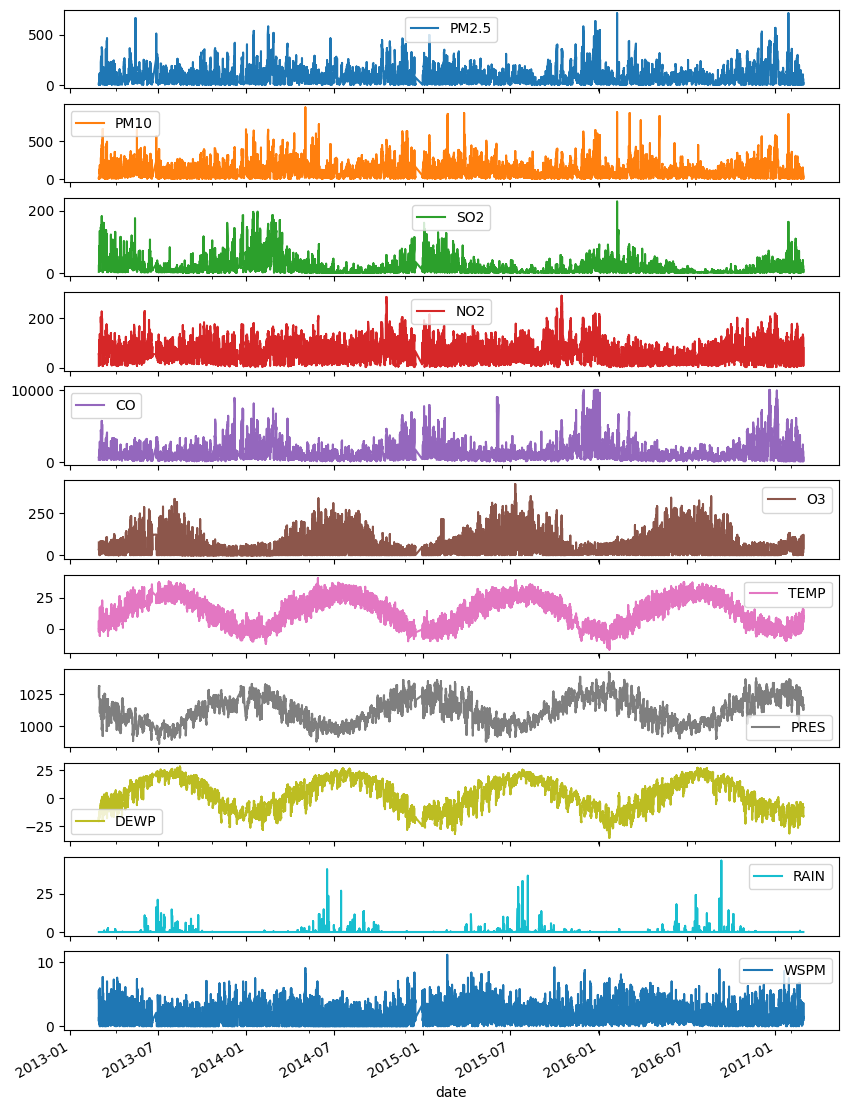

In [128]:
data[data.columns[4:].to_list()].plot(subplots=True,figsize=(10,15))
None

Какие закономерности вы видите на графиках?

**Ответ:** в рядах есть макро сезонность на уровне года. Периодичность наблюдаем по среднему значению признаку либо по его волатильности. Монотонного тренда визуально не наблюдаю

Сгенерируйте новые временные признаки, основываясь на графиках выше. Допишите функцию для создания данных со сдвигом `create_shifted_features`. Помните, что у нас данные поступают каждый час, то есть сдвиг на 1 отвечает сдвигу на 1 час, сдвиг 24 отвечает сдвигу на 1 день, сдвиг на 7*24 отвечает сдвигу на месяц. 

*Указание:* эту функцию нужно использовать для **таргета**!

In [129]:
X, y = create_shifted_features(data['PM10'])

Отделите таргет от признаков. К физическим признакам добавьте временные, полученные в ячейке выше.

In [130]:
X.head(2)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,shift_1,shift_2,shift_3,shift_4,shift_5,week_seasonal_shift_1,year_seasonal_shift_1
date,,,,,,,,,,,,,,
2014-05-04,6,2,5,2014,124,4,18,76.0,53.0,146.0,156.0,35.0,119.0,4.0
2014-05-04,6,2,5,2014,124,4,18,159.0,52.0,160.0,166.0,46.0,108.0,8.0


Разбейте ваши данные таким образом, чтобы в тесте остался последние 20% измерений.

In [131]:
train_size = int(0.8*len(X))
train_X, train_y, test_X, test_y = X[:train_size], y[:train_size], X[train_size:], y[train_size:]

Обучите линейную регрессию с регуляризацией и случайный лес на ваших данных. Допишите функцию `recursive_prediction`.  Посчитайте метрики с помощью функции `calc_metrics`.

In [132]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# линейная регрессия 
l_l1 = Lasso()

l_l1.fit(train_X, train_y)

train_predictions = l_l1.predict(train_X)
calc_metrics(train_predictions, train_y)

y_t_lr = recursive_prediction(l_l1, test_y.index, train_y.to_list())

# случайный лес
rf = RandomForestRegressor(max_depth=3)

rf.fit(train_X, train_y)

train_predictions = rf.predict(train_X)
calc_metrics(train_predictions, train_y)

y_t_rf = recursive_prediction(rf, test_y.index, train_y.to_list())


MSE:  7102.697137244308
MAE:  62.17782901972677
MAPE:  0.5917206572238357
MSE:  6585.349414223081
MAE:  59.52850307906413
MAPE:  0.5777121876612338


Визуализируйте полученные прогнозы с помощью функции `plot_results`.

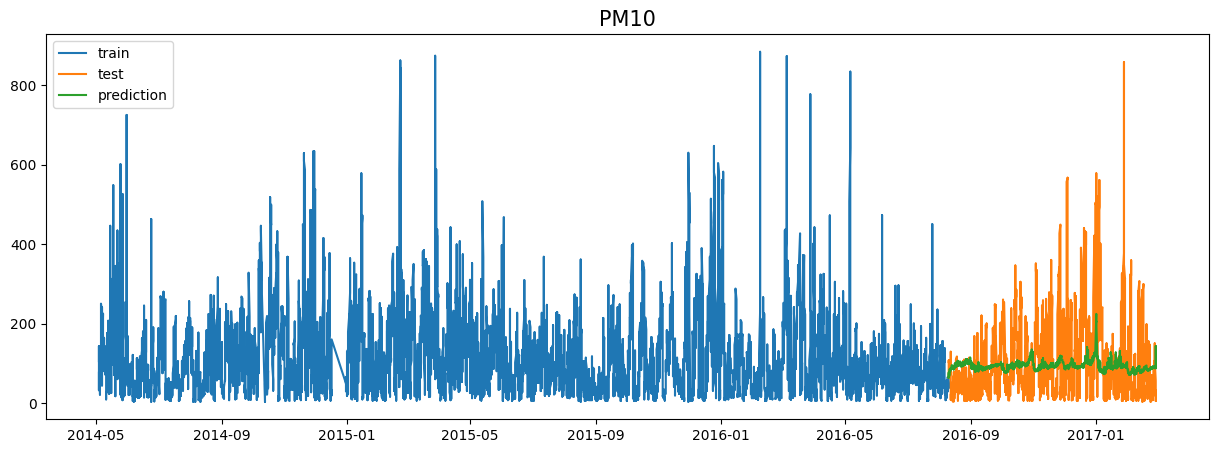

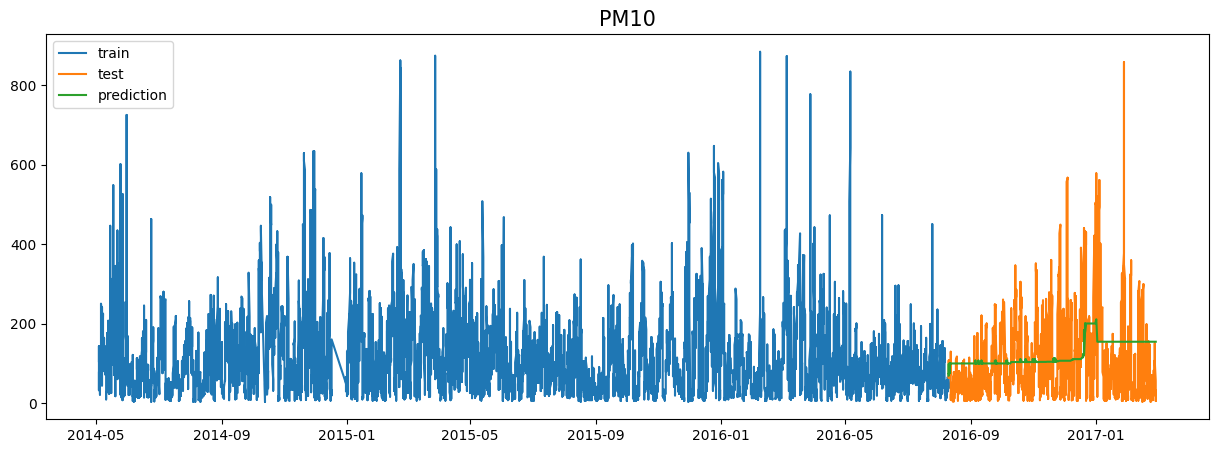

In [133]:
plot_results(train_y,test_y,y_t_lr,title='PM10')
plot_results(train_y,test_y,y_t_rf,title='PM10')

Сделайте выводы.

**Вывод** Успешно предсказываем среднее значение на масштабах года.
Предсказания Random Forest менее волатильны. Признаки не позволяет моделям предсказывать отклонения от сезонного тренда

#### **Профиль биология**

### Загрузка данных
В этом задании вы будете работать с данными о распространении COVID-19, их можно скачать [здесь](https://www.kaggle.com/datasets/gpreda/coronavirus-2019ncov). Мы будем предказывать показатель смертности, потому что способы измерения выздоровевших и заболевших разнятся между регионами.

 В данных представлены следующие столбцы:

* `Country/Region` &mdash; страна или регион,

* `Province/State` &mdash; город или населенный пункт,
* `Latitude` &mdash; географическая широта,
* `Longitude` &mdash; географическая долгота,
* `Confirmed` &mdash; кол-во подтвержденных случаев заболевания,
* `Recovered` &mdash; кол-во подтвержденных случаев выздоровления,
* `Deaths` &mdash; кол-во смертей,
* `Date` &mdash; дата. 

Загрузим данные.

In [136]:
data = pd.read_csv('covid-19-all.csv')

C:\Users\bug\AppData\Local\Temp\ipykernel_7084\2697402599.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('covid-19-all.csv')


Колонку `Date` преобразуем к правильному типу данных и поставим вместо индексов.

In [137]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

Выберите любую страну из колонки `Country/Region` и любой крупный город из колонки `Province/State` (значения `Deaths` не должны опускаться ниже 2500). Обрежьте ваш датасет, чтобы в нем осталась информация только о выбранном городе.

In [138]:
display(data['Country/Region'].value_counts())
data = data.loc[data['Country/Region']=='US']

US                     897495
Russia                  17884
China                   11285
Japan                   10758
India                    7669
                        ...  
Taipei and environs         1
St. Martin                  1
North Ireland               1
Cape Verde                  1
East Timor                  1
Name: Country/Region, Length: 218, dtype: int64

In [139]:
display(data['Province/State'].value_counts())
data = data.loc[data['Province/State']=='Georgia']

Texas                    68851
Georgia                  45712
Virginia                 38038
Kentucky                 33587
Missouri                 31925
                         ...  
Collin County, TX            1
Jefferson County, KY         1
Jefferson Parish, LA         1
Shasta County, CA            1
Santa Cruz County, CA        1
Name: Province/State, Length: 199, dtype: int64

Оставьте в ваших данных только столбец `Deaths`.

In [140]:
dataset = data['Deaths'].groupby('Date').sum()
dataset

Date
2020-03-10        0.0
2020-03-11        0.0
2020-03-12        1.0
2020-03-13        1.0
2020-03-14        1.0
               ...   
2020-12-27    10689.0
2020-12-28    10696.0
2020-12-29    10779.0
2020-12-30    10846.0
2020-12-31    10934.0
Name: Deaths, Length: 297, dtype: float64

Визуализируйте, как изменяется таргет с течением времени. Какие зависимости вы можете увидеть?

<AxesSubplot: xlabel='Date'>

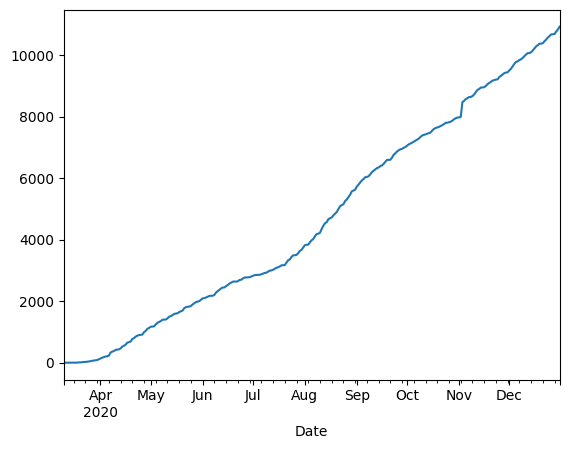

In [143]:
dataset.plot()

**Ответ:** Число смертей монотонно возрастает. Ряд не волатилен

Сгенерируйте новые временные признаки, основываясь на графиках выше. Допишите функцию для создания данных со сдвигом `create_shifted_features`. Помните, что у нас данные поступают каждый день, то есть сдвиг на 1 отвечает сдвигу на 1 день, сдвиг 7 отвечает сдвигу на 1 неделю, сдвиг на 365 отвечает сдвигу на год. 



In [177]:
X, y = create_shifted_features(dataset, year_seasonal_shifts=0,mult=1,shifts=25)

Разбейте ваши данные таким образом, чтобы в тесте остался последние 20% измерений.

In [178]:
train_size = int(0.8*len(X))
train_X, train_y, test_X, test_y = X[:train_size], y[:train_size], X[train_size:], y[train_size:]

Обучите линейную регрессию с регуляризацией и случайный лес на ваших данных. Допишите функцию `recursive_prediction`. Посчитайте метрики с помощью функции `calc_metrics`.

In [181]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from functools import partial

# линейная регрессия 
l_l1 = Lasso()

l_l1.fit(train_X, train_y)

train_predictions = l_l1.predict(train_X)
calc_metrics(train_predictions, train_y)

y_t_lr = recursive_prediction(l_l1, test_y.index, train_y.to_list(),features_creation_function=partial(row_features,mult=1,year_seasonal_shifts=0,shifts=25))

# случайный лес
rf = RandomForestRegressor(max_depth=3)

rf.fit(train_X, train_y)

train_predictions = rf.predict(train_X)
calc_metrics(train_predictions, train_y)

y_t_rf = recursive_prediction(rf, test_y.index, train_y.to_list(),features_creation_function=partial(row_features,mult=1,year_seasonal_shifts=0,shifts=25))


c:\Users\bug\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+05, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(


MSE:  1389.708939864037
MAE:  20.318251398385996
MAPE:  0.00884536050474845
MSE:  39637.200514089745
MAE:  159.86133236270715
MAPE:  0.07743585082376478


Визуализируйте полученные прогнозы с помощью функции `plot_results`.

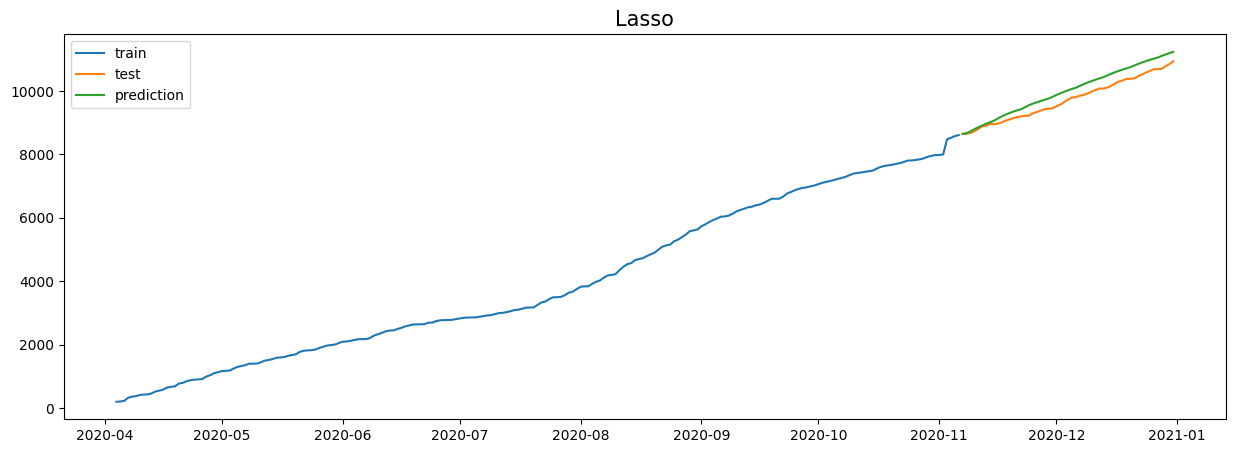

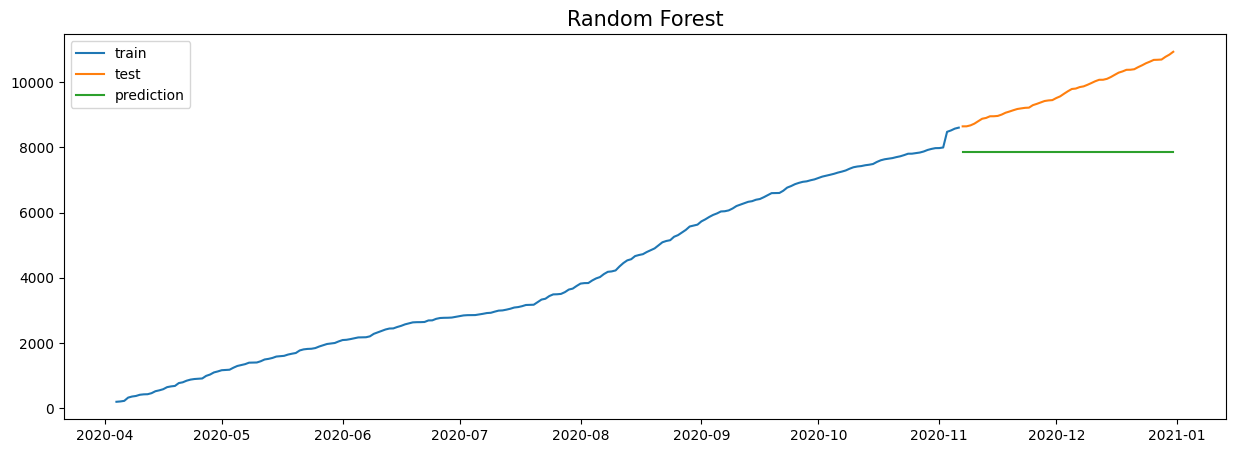

In [182]:
plot_results(train_y,test_y,y_t_lr,title='Lasso')
plot_results(train_y,test_y,y_t_rf,title='Random Forest')

Сделайте выводы.

**Вывод:** регрессионные деревянные алгоритмы не способны на экстраполяцию. Не могут предсказывать монотонный рост временного ряда
Линейная регрессия с заданной задачей справляется

## Задача 2

Вспомним, что при построении деревьев в задаче регрессии для каждого листа вычисляется среднее по всем обучающим объектам, которые попали в данный лист. Тем самым значение в листе лежит в пределах области значений таргета на обучении (не превосходит максимального, не меньше минимального). В связи с этим деревья не могут предсказывать значения за пределами этой области. Зависимости в задачах временных рядов не редко имеют некоторый тренд, например, значения на тестовой части временного ряда могут оказаться вне области значений обучающей части ряда. Это означает, что решающее дерево не сможет построить хороший прогноз временного ряда. Проблема также распространяется на случайный лес. 

В данной задаче вы реализуете другой способ прогнозирования временных рядов, который может решить эту проблему.

Исследуйте `Ridge`, `Lasso` и `ElasticNet` с различными параметрами на данных из предыдущей задачи. Подберите лучшую линейную модель.

In [183]:
from sklearn.linear_model import Ridge,Lasso,ElasticNet
l_models = [Ridge(),Lasso(),ElasticNet(l1_ratio=0.2),ElasticNet(l1_ratio=0.8)]

for l_model in l_models:
    l_model.fit(train_X, train_y)
    test_predictions = recursive_prediction(l_model, test_y.index, train_y.to_list(),features_creation_function=partial(row_features,mult=1,year_seasonal_shifts=0,shifts=25))
    print(f'Метрики {l_model.__class__.__name__}')
    calc_metrics(test_predictions, test_y)

Метрики Ridge
MSE:  886978.817213368
MAE:  887.3623974302141
MAPE:  0.08174027359298305
Метрики Lasso
MSE:  87822.09640114952
MAE:  273.621939008003
MAPE:  0.026754271255421253
Метрики ElasticNet
MSE:  85050.58911558372
MAE:  269.35539018312795
MAPE:  0.02635684947458653


c:\Users\bug\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+05, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\bug\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e+05, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\bug\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

Метрики ElasticNet
MSE:  85584.27885354582
MAE:  270.01069754420587
MAPE:  0.026412064919604822


Elastic net имеет лучшие результаты

Посчитайте остатки прогноза вашей модели на тренировочной выборке. Остатком является разность истинного значния и спрогнозированного.

In [185]:
l_model = ElasticNet(l1_ratio=0.2)
l_model.fit(train_X, train_y)
loss = train_y - l_model.predict(train_X)
y_pred = recursive_prediction(l_model, test_y.index, train_y.to_list(),features_creation_function=partial(row_features,mult=1,year_seasonal_shifts=0,shifts=25))

c:\Users\bug\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e+05, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(


Теперь сделаем необычный ход &mdash; научим случайный лес предсказывать ошибку линейной модели. Для этого за `Х` возьмем исходные признаки, а за `y` - вектор разностей, который вы посчитали в ячейке выше.

Предскажем ошибку линейной модели на тестовой выборке. Получим вектор предсказанных ошибок.

In [186]:
rf = RandomForestRegressor(max_depth=3)
rf.fit(train_X,loss)
errors_pred =  recursive_prediction(rf, test_y.index, loss.to_list(),features_creation_function=partial(row_features,mult=1,year_seasonal_shifts=0,shifts=25))

Теперь сложим прогноз линейной модели для тестовой выборки и прогноз ошибок случайного леса для этой же тестовой выборки. Посчитайте метрики для полученного вектора.

In [187]:
calc_metrics(train_y,l_model.predict(train_X) )
calc_metrics(train_y, rf.predict(train_X)+l_model.predict(train_X))
calc_metrics(test_y, y_pred)
calc_metrics(test_y, y_pred+errors_pred)

MSE:  1391.6917617466784
MAE:  20.357273159622224
MAPE:  0.008511252433897
MSE:  548.16389221839
MAE:  16.144645530438275
MAPE:  0.007223107383933746
MSE:  85050.58911558372
MAE:  269.35539018312795
MAPE:  0.027183241726871987
MSE:  99408.76110795689
MAE:  294.4252670419794
MAPE:  0.029771225018685718


Визуализируйте новый прогноз.

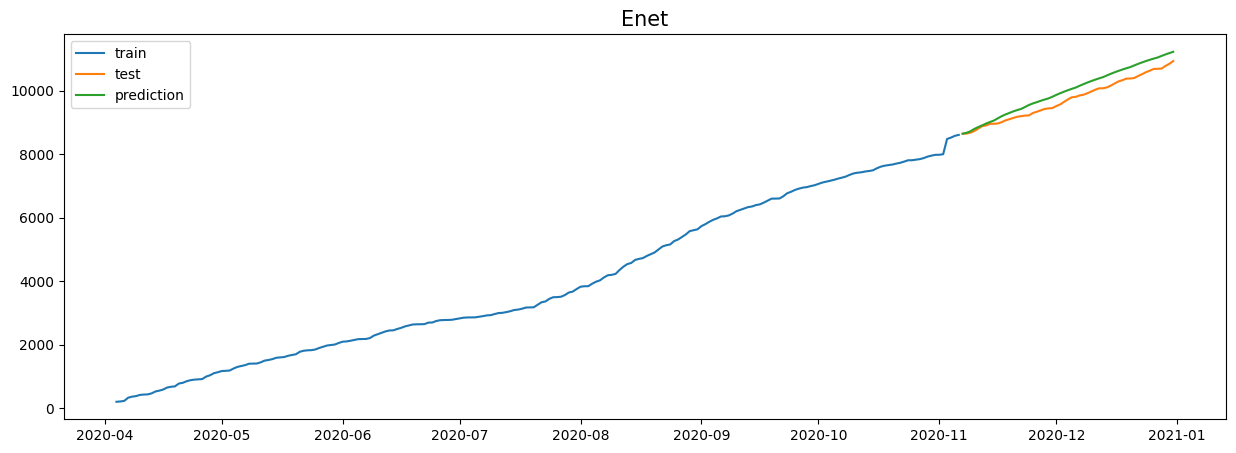

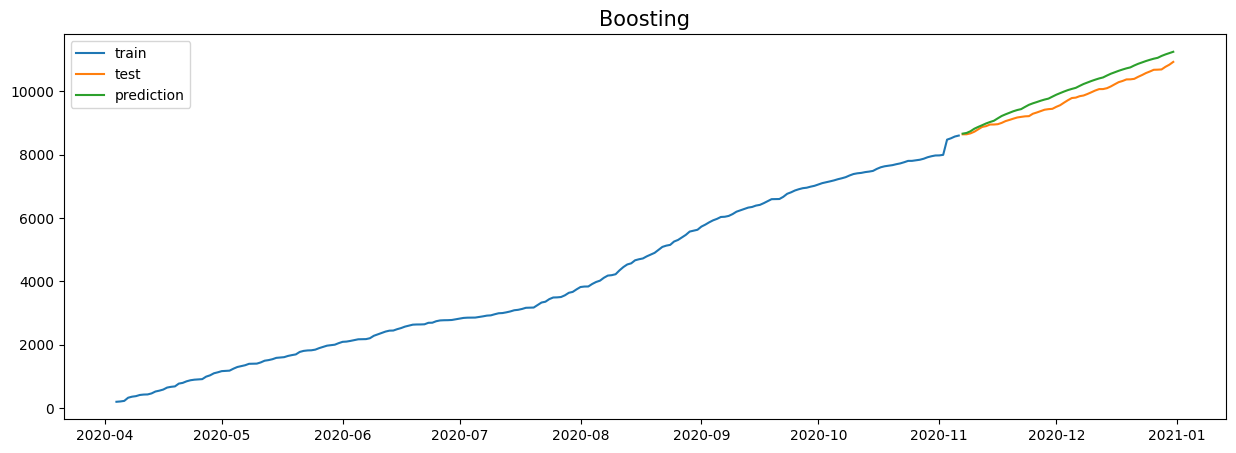

In [188]:
plot_results(train_y,test_y,y_pred,title='Enet')
plot_results(train_y,test_y,y_pred+errors_pred,title='Boosting')

Сделайте вывод.

**Вывод:** Процедура бустинга позволяет достичь лучшие результаты на train, на тесте ошибаемся больше 

Процедура, которую вы сейчас провели, называется **бустинг**. В этой модели последовательно объединяются деревья, которые учатся предсказывать ошибку предыдущего дерева. Благодаря такой схеме модели удается достичь высокого качества. Подробнее с бустингом мы ознакомимся в следующем семестре.